# Wineries Mini-Project

## 0.0 - Intro & setup

### 0.1 - Intro

Data:
- ESGF (CEDA)
- UKCP18
- ERA5

Code:
- I/O function
- Analysis function
  - Produces metrics
- Plotting
  - Maps?
  - Timeseries?
  - anything really - just show your outputs

Important variables:
- Temperature
- Precipitation

Choose one scenario to start - make sure it works

#### 0.1.1 - Places to get data:

- [CEDA](https://catalogue.ceda.ac.uk/?record_types=Observation&q=)
  - Can be used to [access ESGF data](https://esgf-ui.ceda.ac.uk/cog/projects/esgf-ceda/)
- [CDS](https://accounts.ecmwf.int/auth/realms/ecmwf/login-actions/registration?client_id=cds&tab_id=7RYqVL1Y1QE)
  - ERA5 data - a reanalysis product (not actual measurements, but contains measurements and the rest is inferred via known laws of physics)
- [UKCP18](https://ukclimateprojections-ui.metoffice.gov.uk/products)
  -  Higher resolution than other outputs for the UK (2.2km resolution over the UK, 12km nearby (europe?), 60km elsewhere)
  - All data available via CEDA, but it may be easier to find here.
  - Variable abbreviations available [here (page 10)](https://www.metoffice.gov.uk/binaries/content/assets/metofficegovuk/pdf/research/ukcp/ukcp18-guidance-data-availability-access-and-formats.pdf)

Also:
- [JASMIN](https://jasmin.ac.uk/about/)
  - Computing resource, alongside data store. Makes it very fast for analysis.
  - Not registered - unlikely to be approved without a good reason for an account

#### 0.1.2 - Plan

Question:
> **Should French Champagne makers invest in wineries in Hampshire (UK)?**

What do we need to know:
- What makes a region good to grow the grapes required for sparkling wine? What is the metric?
  - Temperature (mins will likely have the biggest effect, as this could kill the grape. maxs may do something too, as well as avg temp. need to look into)
  - Cloud cover?
- Given the metric, does Hampshire outperform a. the current winery regions (e.g. Champagne), and b. alternatives elsewhere in Europe

What's good for wines:
- https://www.tandfonline.com/doi/full/10.1080/1747423X.2018.1537312
  - Lack of extreme temperatures
  - Stable temperatures year-on-year - wineries want to be able to rely upon their yield year-on-year. If there's high variance there will be an appreciable chance of a random low yield.
  - Soil, topography, land use
    - Soil - need to have the right sort of nutrients etc.
    - Topography & land use - need to be able to build a vineyard that's large enough to produce something profitable. If there's nowhere in the UK you could do this (e.g. due to national parks, cities etc.) then there's no point in considering.

Further things to note:
- Need confidence in our outputs (analysis of analysis) 
  - show if our results are backed up by multiple models.
  - How dependent upon scenario are the results?
  - How dependent are our results upon spatial distribution? Does the same happen to france, or other regions in the uK?

### 0.2 - Setup

In [1]:
import cdsapi
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import cfunits
import cartopy

## 1.0 - Code

### 1.1 - Data import

In [2]:
ukcp_test = xr.open_dataset('UKCP18_data/tas_rcp85_land-rcm_eur_12km_04_mon_198012-208011.nc')
max_temp_hamp = xr.open_dataset('UKCP18_data/wineries_max_temp_hamp.nc')
avg_temp_hamp = xr.open_dataset('UKCP18_data/wineries_avg_temp_hamp.nc')
min_temp_hamp = xr.open_dataset('UKCP18_data/wineries_min_temp_hamp.nc')

In [145]:
max_temp_hamp.time.values

array([cftime.Datetime360Day(2020, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2020, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2020, 1, 3, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.Datetime360Day(2079, 12, 28, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2079, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2079, 12, 30, 12, 0, 0, 0, has_year_zero=True)],
      shape=(21600,), dtype=object)

In [4]:
dates = [str(datetime).split()[0] for datetime in max_temp_hamp.time.values]


In [13]:
max_temp_hamp.time.month_number.isin((1,2))

<xarray.DataArray 'month_number' (time: 21600)> Size: 22kB
array([ True,  True,  True, ..., False, False, False], shape=(21600,))
Coordinates:
  * time          (time) object 173kB 2020-01-01 12:00:00 ... 2079-12-30 12:0...
    geo_region    |S18 18B ...
    month_number  (time) int32 86kB 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12
    region        int32 4B ...
    year          (time) int32 86kB ...
    yyyymmdd      (time) |S64 1MB ...

In [17]:
max_temp_hamp.where(max_temp_hamp.time.month_number.isin((5, 6, 7)))

<xarray.Dataset> Size: 3MB
Dimensions:             (ensemble_member: 12, time: 21600, bnds: 2)
Coordinates:
  * ensemble_member     (ensemble_member) int32 48B 1 4 5 6 7 8 9 10 11 12 13 15
  * time                (time) object 173kB 2020-01-01 12:00:00 ... 2079-12-3...
    geo_region          |S18 18B b'South East England'
    ensemble_member_id  (ensemble_member) |S27 324B ...
    month_number        (time) int32 86kB 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12
    region              int32 4B 17
    year                (time) int32 86kB 2020 2020 2020 2020 ... 2079 2079 2079
    yyyymmdd            (time) |S64 1MB b'20200101                           ...
Dimensions without coordinates: bnds
Data variables:
    tasmax              (ensemble_member, time) float32 1MB nan nan ... nan nan
    time_bnds           (time, bnds) object 346kB nan nan nan ... nan nan nan
Attributes: (12/15)
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2021-06-15T00:00:00
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      river
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20210615
    Conventions:     CF-1.7

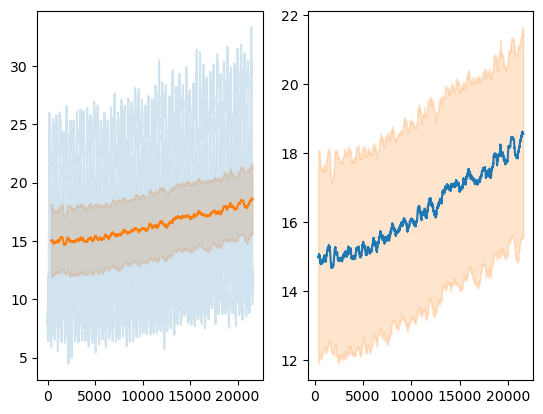

In [ ]:
def plot_timeseries(data, ax_pair):
    data_err = data.std('ensemble_member')
    data_mean = data.mean('ensemble_member')

    mean_ann = data_mean.rolling(time = 360).mean()
    mean_ann_err = data_err.rolling(time = 360).mean()


    # plot means
    ax_pair[0].plot(data_mean, alpha = 0.2, label = 'max temp daily')
    ax_pair[0].fill_between([i for i in range(len(mean_ann_err))], mean_ann - mean_ann_err, mean_ann+mean_ann_err,
                    alpha = 0.2, color = 'tab:orange', label = 'uncertainty in annual mean (from ensemble)')
    ax_pair[0].plot(mean_ann, label = 'max temp rolling annual mean')

    # plot std
    ax_pair[1].fill_between([i for i in range(len(mean_ann_err))], mean_ann - mean_ann_err, mean_ann+mean_ann_err,
                    alpha = 0.2, color = 'tab:orange', label = 'uncertainty in annual mean (from ensemble)')
    ax_pair[1].plot(mean_ann, label = 'max temp rolling annual mean')
    ax_pair[1].title()


fig, axs = plt.subplots(1,2)
plot_timeseries(max_temp_hamp['tasmax'], axs)

    


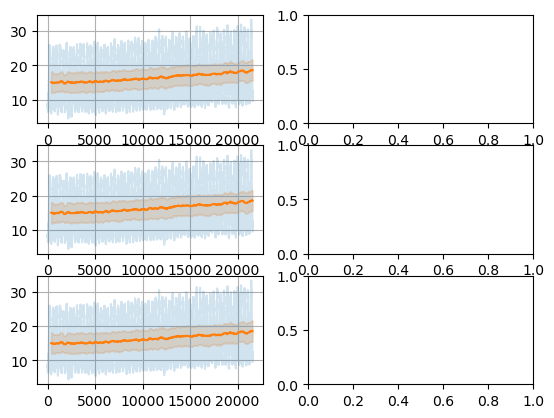

In [47]:
fig, axs = plt.subplots(3,2)

for i, ax_pair in enumerate(axs):
    ax_mean, ax_std = ax_pair
    max_temp_hamp_err = max_temp_hamp['tasmax'].std('ensemble_member')
    max_temp_hamp_mean = max_temp_hamp['tasmax'].mean('ensemble_member')
    mean_ann = max_temp_hamp_mean.rolling(time = 360).mean()
    mean_ann_err = max_temp_hamp_err.rolling(time = 360).mean()
    std_ann = max_temp_hamp_mean.rolling(time = 360).std()

    ax_mean.plot(max_temp_hamp_mean, alpha = 0.2, label = 'max temp daily')
    ax_mean.fill_between([i for i in range(len(mean_ann_err))], mean_ann - mean_ann_err, mean_ann+mean_ann_err,
                    alpha = 0.2, color = 'tab:orange', label = 'uncertainty in annual mean (from ensemble)')
    ax_mean.plot(mean_ann, label = 'max temp rolling annual mean')
    #ax.set_xticklabels(dates)

    ax_mean.grid()
    #ax_mean.legend()
plt.show()

/var/folders/n4/jz0_qc0d73z45fzcx27k4ghh0000gn/T/ipykernel_23148/15715720.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


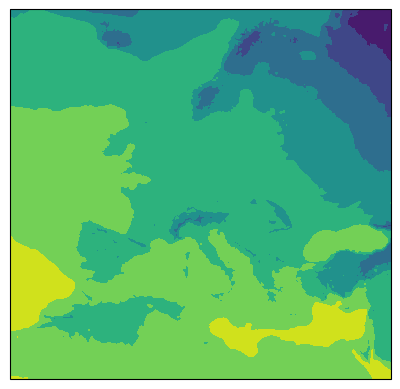

In [73]:
time_ind = 100
transform = cartopy.crs.PlateCarree()
projection = cartopy.crs.PlateCarree()
region = [-8.5,38.5,31,71.5]
def plot_map(array, extent = [-8.5,38.5,31,71.5], 
             lon_label = 'grid_longitude', lat_label = 'grid_latitude',
             variable = 'tas',
             projection = cartopy.crs.PlateCarree()):


    fig = plt.figure()
    ax = fig.add_subplot(111, projection=projection)
    #if extent is not None:
    #    ax.set_extent(extent, projection)
        #ax.coastlines()


    ax.contourf(array[f'{lon_label}'],
                array[f'{lat_label}'],
                array[f'{variable}'],
                transform = projection)
    
    fig.show()

plot_map(ukcp_test.squeeze(['ensemble_member']).isel(time = 0))

In [60]:
ukcp_test.grid_latitude

<xarray.DataArray 'grid_latitude' (grid_latitude: 406)> Size: 3kB
array([-23.044998, -22.934998, -22.824999, ...,  21.285   ,  21.395   ,
        21.505001], shape=(406,))
Coordinates:
  * grid_latitude  (grid_latitude) float64 3kB -23.04 -22.93 ... 21.4 21.51
Attributes:
    axis:           Y
    bounds:         grid_latitude_bnds
    units:          degrees
    standard_name:  grid_latitude

In [ ]:
def plot_timeseries(array, extent = None, 
                    lon_label = 'grid_longitude', lat_label = 'grid_latitude',
                    variable = 'tas'):

In [9]:
ukcp_test.plot.scatter(vars=['tas'])

KeyError: "No variable named None. Variables on the dataset include ['tas', 'rotated_latitude_longitude', 'ensemble_member', 'time', 'time_bnds', ..., 'grid_longitude_bnds', 'ensemble_member_id', 'month_number', 'year', 'yyyymm']"